In [46]:
import os
import numpy as np
import pandas as pd
import gzip

In [47]:
os.chdir('E:/CNSI_project/demo_and_data_3.0/Raw_data/eICU/')
pd.set_option('display.max_columns', None)

In [48]:
filename = './microLab.csv.gz'
with gzip.open(filename, 'rt', encoding='utf-8') as file:
    df = pd.read_csv(file)
df

,microlabid,patientunitstayid,culturetakenoffset,culturesite,organism,antibiotic,sensitivitylevel
0,549559,983524,-688,"Blood, Venipuncture",gram positive rods,NaN,NaN
1,549555,983524,-5481,Stool,no growth,NaN,NaN
2,549565,983524,324,Stool,no growth,NaN,NaN
3,549562,983524,-686,"Blood, Central Line",gram negative rods,NaN,NaN
4,549564,983524,-681,"Blood, Central Line",gram positive cocci,NaN,NaN
...,...,...,...,...,...,...,...
16991,1617032,3160582,411,Other,mixed flora,NaN,NaN
16992,1617031,3160582,-521,"Blood, Venipuncture",no growth,NaN,NaN
16993,1617033,3160582,411,Other,Candida albicans,NaN,NaN
16994,1617030,3160582,-522,"Blood, Venipuncture",no growth,NaN,NaN


In [49]:
print([each for each in df['culturesite'].unique() if 'CSF' in each])
df['culturesite'].unique()

['CSF']


array(['Blood, Venipuncture', 'Stool', 'Blood, Central Line',
       'Urine, Voided Specimen', 'Sputum, Tracheal Specimen',
       'Nasopharynx', 'Urine, Catheter Specimen', 'Sputum, Expectorated',
       'Bronchial Lavage', 'CSF', 'Other', 'Wound, Drainage Fluid',
       'Wound, Decubitus', 'Abscess', 'Pleural Fluid', 'Peritoneal Fluid',
       'Wound, Surgical', 'Bile', 'Rectal Swab', 'Skin'], dtype=object)

In [50]:
# 提取出做了CSF菌培养的病人
df1 = df[df['culturesite'].str.contains('CSF')]
df1

,microlabid,patientunitstayid,culturetakenoffset,culturesite,organism,antibiotic,sensitivitylevel
83,551846,1047047,15008,CSF,no growth,NaN,NaN
93,551984,1047047,17408,CSF,no growth,NaN,NaN
97,550659,1047047,3043,CSF,no growth,NaN,NaN
161,834790,2573296,-130,CSF,no growth,NaN,NaN
343,837305,2576788,1230,CSF,no growth,NaN,NaN
...,...,...,...,...,...,...,...
16121,1627693,3157971,900,CSF,no growth,NaN,NaN
16141,1634331,3158058,8389,CSF,no growth,NaN,NaN
16143,1634332,3158058,8389,CSF,no growth,NaN,NaN
16462,1610437,3158913,-127,CSF,no growth,NaN,NaN


In [51]:
df1[['organism']].value_counts()

organism                       
no growth                          57
Other                              31
Streptococcus pneumoniae            4
yeast                               2
Staphylococcus aureus               1
gram positive cocci                 1
gram positive cocci - in chains     1
dtype: int64

In [52]:
# other被我过滤掉，不知道是否妥当
list1 = ['no growth']
list2 = ['Streptococcus pneumoniae','yeast','Staphylococcus aureus','gram positive cocci','gram positive cocci - in chains']
def culture(outcome):
    if outcome in list1:
        return 0
    elif outcome in list2:
        return 1
    else:
        np.nan
df2 = df1.copy()
df2['culture'] = df2['organism'].apply(lambda x: culture(x))
df2 = df2[(df2['culture']==0) | (df2['culture']==1)]  # 要加括号，要不然出错
df2

,microlabid,patientunitstayid,culturetakenoffset,culturesite,organism,antibiotic,sensitivitylevel,culture
83,551846,1047047,15008,CSF,no growth,NaN,NaN,0.0
93,551984,1047047,17408,CSF,no growth,NaN,NaN,0.0
97,550659,1047047,3043,CSF,no growth,NaN,NaN,0.0
161,834790,2573296,-130,CSF,no growth,NaN,NaN,0.0
343,837305,2576788,1230,CSF,no growth,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
16121,1627693,3157971,900,CSF,no growth,NaN,NaN,0.0
16141,1634331,3158058,8389,CSF,no growth,NaN,NaN,0.0
16143,1634332,3158058,8389,CSF,no growth,NaN,NaN,0.0
16462,1610437,3158913,-127,CSF,no growth,NaN,NaN,0.0


In [53]:
df2['culture'].value_counts()

0.0    57
1.0     9
Name: culture, dtype: int64

In [54]:
# 挑出同一次住院产生不同菌培养结果的情况
groups = df2.groupby(['patientunitstayid'])['culture'].apply(lambda x: x.dropna().nunique()>1)
filtered_data = groups[groups].reset_index()[['patientunitstayid']]
df_filtered = df2.merge(filtered_data, on=['patientunitstayid'],how='inner')
df_filtered

,microlabid,patientunitstayid,culturetakenoffset,culturesite,organism,antibiotic,sensitivitylevel,culture
0,839204,2583429,-2858,CSF,no growth,NaN,NaN,0.0
1,840020,2583429,-12995,CSF,yeast,NaN,NaN,1.0


In [55]:
(12995-2858)/60/24

7.039583333333333

In [56]:
# 若同一个病人多次采样的结果不同，且不同结果的采样时间相差在24小时以内，则将他们的culture结果都变为1
df3 = df2.copy()
df3.sort_values(['patientunitstayid', 'culturetakenoffset'], inplace=True)

def adjust_culture(group):
    # 如果病人只有一次采样，或者所有采样结果都相同，不需要修改
    if len(group['culture'].unique()) == 1:
        return group
    else:
        # 找出时间差在24小时以内的连续采样
        group['time_diff'] = group['culturetakenoffset'].diff()
        mask = (group['culture'].diff().abs() == 1) & (group['time_diff'] <= 1440)
        # 如果存在这样的采样，将这两次culture结果变为1
        group.loc[mask | mask.shift(-1), 'culture'] = 1
        return group

df3 = df3.groupby('patientunitstayid').apply(adjust_culture)

# 删除创建的time_diff列
df3.drop(columns='time_diff', inplace=True)
df3

,microlabid,patientunitstayid,culturetakenoffset,culturesite,organism,antibiotic,sensitivitylevel,culture
97,550659,1047047,3043,CSF,no growth,NaN,NaN,0.0
83,551846,1047047,15008,CSF,no growth,NaN,NaN,0.0
93,551984,1047047,17408,CSF,no growth,NaN,NaN,0.0
161,834790,2573296,-130,CSF,no growth,NaN,NaN,0.0
343,837305,2576788,1230,CSF,no growth,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
16121,1627693,3157971,900,CSF,no growth,NaN,NaN,0.0
16141,1634331,3158058,8389,CSF,no growth,NaN,NaN,0.0
16143,1634332,3158058,8389,CSF,no growth,NaN,NaN,0.0
16462,1610437,3158913,-127,CSF,no growth,NaN,NaN,0.0


In [57]:
df3['culture'].value_counts()

0.0    57
1.0     9
Name: culture, dtype: int64

In [58]:
df3[df3['patientunitstayid']==2583429]

,microlabid,patientunitstayid,culturetakenoffset,culturesite,organism,antibiotic,sensitivitylevel,culture
572,840020,2583429,-12995,CSF,yeast,NaN,NaN,1.0
568,839204,2583429,-2858,CSF,no growth,NaN,NaN,0.0


In [59]:
# 若同一个病人在24小时内有多次相同的采样结果，则只取第一个结果的行数据。
df3.sort_values(['patientunitstayid', 'culturetakenoffset'], inplace=True)

def remove_duplicates(group):
    # 如果病人只有一次采样，不需要修改
    if len(group) == 1:
        return group
    else:
        # 找出在24小时内有多次相同的采样结果
        group['time_diff'] = group['culturetakenoffset'].diff()
        mask = (group['culture'] == group['culture'].shift()) & (group['time_diff'] <= 1440)
        # 删除这些重复的结果，只保留第一个
        group = group[~mask]
        return group

df3 = df3.groupby('patientunitstayid').apply(remove_duplicates)

# 删除创建的time_diff列
df3.drop(columns='time_diff', inplace=True)
df3

microlabid  patientunitstayid  culturetakenoffset  \
patientunitstayid                                                            
1047047           97         550659            1047047                3043   
                  83         551846            1047047               15008   
                  93         551984            1047047               17408   
2573296           161        834790            2573296                -130   
2576788           343        837305            2576788                1230   
2578536           407        835579            2578536                -990   
2581002           456        835302            2581002               14169   
2582617           522        834764            2582617               20225   
2582970           538        837993            2582970                1031   
2583126           541        835548            2583126                -476   
2583429           572        840020            2583429              -12995   
                  568        839204            2583429               -2858   
2583789           581        835201            2583789                -159   
2588350           718        837980            2588350                -554   
2588558           721        835715            2588558               15495   
2589249           738        835503            2589249               25452   
2590832           898        832809            2590832                1160   
2597361           1155       837174            2597361                -438   
2597831           1171       839789            2597831              -28395   
2601479           1265       837746            2601479                -230   
2601903           1267       837478            2601903                 -87   
2602402           1297       838146            2602402                1356   
2602626           1353       832866            2602626                 605   
2602968           1362       837093            2602968               37045   
                  1370       837162            2602968               48450   
                  1384       837502            2602968               65649   
2604537           1414       833363            2604537                7870   
2605795           1459       832810            2605795                3180   
2608009           1517       834008            2608009                 950   
2615832           1698       839969            2615832                -246   
2618787           1830       835493            2618787               -7564   
2626224           2108       834878            2626224                  76   
2638728           2395       839890            2638728               -2708   
2638853           2404       833112            2638853                7062   
2640095           2411       837431            2640095                 104   
2644964           2540       834329            2644964                6776   
                  2539       834393            2644964               12486   
3131170           5938      1583087            3131170                 724   
3131763           6234      1635664            3131763                2814   
3131909           6300      1603221            3131909                -515   
3133623           6912      1635347            3133623                 130   
3135561           7730      1631697            3135561                -620   
3136367           7962      1579680            3136367                 976   
3137362           8243      1609437            3137362                -344   
3139077           8905      1634403            3139077                1037   
3139600           9063      1635313            3139600               -3988   
3141147           9743      1581855            3141147                 258   
3141371           9841      1626488            3141371                1206   
3142740           10331     1615278            3142740                9637   
3144241           10895     1621319            

In [60]:
df3['culture'].value_counts()

0.0    55
1.0     4
Name: culture, dtype: int64

In [61]:
df3[df3['patientunitstayid']==2583429]

microlabid  patientunitstayid  culturetakenoffset  \
patientunitstayid                                                          
2583429           572      840020            2583429              -12995   
                  568      839204            2583429               -2858   

                      culturesite   organism antibiotic sensitivitylevel  \
patientunitstayid                                                          
2583429           572         CSF      yeast        NaN              NaN   
                  568         CSF  no growth        NaN              NaN   

                       culture  
patientunitstayid               
2583429           572      1.0  
                  568      0.0

In [62]:
df3 = df3.reset_index(drop=True)
df3

,microlabid,patientunitstayid,culturetakenoffset,culturesite,organism,antibiotic,sensitivitylevel,culture
0,550659,1047047,3043,CSF,no growth,NaN,NaN,0.0
1,551846,1047047,15008,CSF,no growth,NaN,NaN,0.0
2,551984,1047047,17408,CSF,no growth,NaN,NaN,0.0
3,834790,2573296,-130,CSF,no growth,NaN,NaN,0.0
4,837305,2576788,1230,CSF,no growth,NaN,NaN,0.0
5,835579,2578536,-990,CSF,no growth,NaN,NaN,0.0
6,835302,2581002,14169,CSF,no growth,NaN,NaN,0.0
7,834764,2582617,20225,CSF,no growth,NaN,NaN,0.0
8,837993,2582970,1031,CSF,no growth,NaN,NaN,0.0
9,835548,2583126,-476,CSF,gram positive cocci - in chains,NaN,NaN,1.0


In [63]:
df3['patientunitstayid'].value_counts()

1047047    3
2602968    3
2644964    2
2583429    2
3141147    1
3131170    1
3131763    1
3131909    1
3133623    1
3135561    1
3136367    1
3137362    1
3139077    1
3139600    1
3141371    1
2638853    1
3142740    1
3144241    1
3144382    1
3147081    1
3153395    1
3155519    1
3155904    1
3157971    1
3158058    1
3158913    1
2640095    1
2626224    1
2638728    1
2590832    1
2576788    1
2578536    1
2581002    1
2582617    1
2582970    1
2583126    1
2583789    1
2588350    1
2588558    1
2589249    1
2597361    1
2573296    1
2597831    1
2601479    1
2601903    1
2602402    1
2602626    1
2604537    1
2605795    1
2608009    1
2615832    1
2618787    1
3159526    1
Name: patientunitstayid, dtype: int64

# 提取以及合并lab的数据

In [64]:
filename = './lab.csv.gz'
with gzip.open(filename, 'rt', encoding='utf-8') as file:
    df4 = pd.read_csv(file)
df4

,labid,patientunitstayid,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
0,52307161,141168,2026,3,fibrinogen,177.00,177,mg/dL,mg/dL,2219
1,50363251,141168,1133,3,PT - INR,2.50,2.5,ratio,NaN,1208
2,49149139,141168,2026,1,magnesium,2.00,2.0,mg/dL,mg/dL,2090
3,50363250,141168,1133,3,PT,26.60,26.6,sec,sec,1208
4,66695374,141168,2141,7,pH,7.20,7.20,NaN,Units,2155
...,...,...,...,...,...,...,...,...,...,...
39132526,824772675,3353263,-7,3,WBC x 1000,6.40,6.4,K/mcL,K/uL,6
39132527,826470517,3353263,1733,3,RBC,4.67,4.67,M/mcL,M/uL,1774
39132528,824772678,3353263,-7,3,-monos,10.00,10,%,%,6
39132529,826470516,3353263,1733,3,WBC x 1000,6.60,6.6,K/mcL,K/uL,1774


In [65]:
# 从lab数据中选出做过CSF菌培养的patientunitstayid
df5 = df4.copy()
df5 = df5[df5['patientunitstayid'].isin(df3['patientunitstayid'])]
df5

,labid,patientunitstayid,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
11131632,245475050,1047047,32548,3,PT - INR,1.000,1.0,ratio,NaN,32587
11131633,247443294,1047047,29399,4,bedside glucose,128.000,128,mg/dL,mg/dL,29401
11131634,248022362,1047047,8135,4,urinary specific gravity,1.022,1.022,NaN,NaN,8152
11131635,247202351,1047047,27619,4,bedside glucose,95.000,95,mg/dL,mg/dL,27620
11131636,248351985,1047047,38353,4,bedside glucose,125.000,125,mg/dL,mg/dL,38354
...,...,...,...,...,...,...,...,...,...,...
35917083,774220676,3159526,28240,1,total bilirubin,0.200,0.2,mg/dL,mg/dL,28277
35917084,773979508,3159526,15267,1,sodium,141.000,141,mmol/L,mmol/L,15321
35917085,774236801,3159526,10985,1,ALT (SGPT),150.000,150,Units/L,U/L,11064
35917086,774054328,3159526,28240,1,phosphate,5.500,5.5,mg/dL,mg/dL,28277


In [66]:
# 根据MIMIC中的feature从eICU中挑选出有用的feature
df6 = df5.copy()
# useful_labname = ['lactate','-lymphs','-eos','RBC','WBC x 1000','-polys', '-monos','-basos','glucose', 'total protein', '-bands',"WBC's in cerebrospinal fluid",'protein - CSF', 'glucose - CSF']
# df6 = df6[df6['labname'].isin(useful_labname)]
df6

,labid,patientunitstayid,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
11131632,245475050,1047047,32548,3,PT - INR,1.000,1.0,ratio,NaN,32587
11131633,247443294,1047047,29399,4,bedside glucose,128.000,128,mg/dL,mg/dL,29401
11131634,248022362,1047047,8135,4,urinary specific gravity,1.022,1.022,NaN,NaN,8152
11131635,247202351,1047047,27619,4,bedside glucose,95.000,95,mg/dL,mg/dL,27620
11131636,248351985,1047047,38353,4,bedside glucose,125.000,125,mg/dL,mg/dL,38354
...,...,...,...,...,...,...,...,...,...,...
35917083,774220676,3159526,28240,1,total bilirubin,0.200,0.2,mg/dL,mg/dL,28277
35917084,773979508,3159526,15267,1,sodium,141.000,141,mmol/L,mmol/L,15321
35917085,774236801,3159526,10985,1,ALT (SGPT),150.000,150,Units/L,U/L,11064
35917086,774054328,3159526,28240,1,phosphate,5.500,5.5,mg/dL,mg/dL,28277


In [67]:
df6['labname'].unique().shape

(115,)

In [68]:
# 合并df3和df6
df = pd.merge(df3, df6, on='patientunitstayid')

# 计算时间差，筛选出在24小时内的检测结果
df['time_diff'] = (df['labresultoffset'] - df['culturetakenoffset']).abs()
df = df[df['time_diff'] <= 60*24*1]

# 删除我们创建的time_diff列
df.drop(columns='time_diff', inplace=True)

# 将labresult列转为字符串
df['labresult'] = df['labresult'].astype(str)

# 将每种检测结果转为一列，并用~连接多次检测的结果
df_result = df.groupby(['patientunitstayid', 'culturetakenoffset', 'culture', 'labname'])['labresult'].apply('~'.join).unstack()

# 重置index
df_result.reset_index(inplace=True)
df_result.columns.name = None  # 摆脱dataframe python中显示在索引顶部/上方的列/轴名称：重命名轴
df_result

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity
0,1047047,3043,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0~3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1~27.9,9.3~8.6,NaN,NaN,NaN,27.0~26.8,30.9~30.8,87.5~86.9,10.9~10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.44~3.21,20.0~20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.6~13.5,112.0,NaN,NaN,NaN,NaN,6.0~7.0,103.0~107.0,25.0~27.0,8.0~8.2,111.0~111.0,NaN,0.5~0.42,NaN,NaN,NaN,NaN,NaN,129.0~106.0,69.0,NaN,NaN,NaN,NaN,2.1~2.5,NaN,NaN,NaN,NaN,NaN,260.0~257.0,3.7~3.9,NaN,177.0,NaN,NaN,142.0~145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032
1,1047047,15008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0~6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.3~26.3,8.5~8.3,NaN,NaN,NaN,27.2~27.3,31.1~31.6,87.5~86.5,10.0~9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.12~3.04,20.5~20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.1~16.0,142.0,NaN,NaN,NaN,NaN,10.0~8.0,129.0~125.0~119.0~139.0~133.0~116.0~132.0~142....,28.0~28.0,8.5~7.9,101.0~103.0,NaN,0.4~0.4,NaN,NaN,NaN,NaN,NaN,107.0~118.0,72.0,NaN,NaN,NaN,NaN,3.1~3.1~3.3~3.3,NaN,NaN,NaN,NaN,NaN,418.0~405.0,3.9~3.8,NaN,69.0,NaN,NaN,138.0~139.0~137.0~139.0~138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,166.0,1.025
2,1047047,17408,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,29.0,NaN,25.9,8.0,NaN,NaN,NaN,27.0,30.9,87.5,9.8,NaN,NaN,98.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20.6,NaN,NaN,NaN,NaN,NaN,NaN,30.0,nan,NaN,NaN,17.2,NaN,NaN,NaN,NaN,NaN,8.0,117.0~125.0~129.0~116.0~122.0~124.0~110.0,29.0,8.8,102.0,NaN,0.4,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,36.9,91.0,NaN,425.0,3.5,NaN,NaN,NaN,NaN,139.0~139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2573296,-130,0.0,NaN,NaN,0.0,7.0,5.0,88.0,35.0,31.0,NaN,NaN,15.0~14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,16.1,NaN,NaN,NaN,31.0,35.0,90.0,10.5,NaN,NaN,NaN,NaN,NaN,13.6,1.1,25.0,NaN,NaN,NaN,5.15,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.55,108.0,4.5,87.0,NaN,NaN,13.0~10.0,91.0~83.0~121.0~88.0,26.0~26.0,9.6~8.9,102.0~104.0,NaN,0.5~0.5,NaN,NaN,337.0,NaN,NaN,93.0~102.0,51.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,452.0,3.8~4.0,NaN,NaN,NaN,NaN,140.0~141.0,0.5,NaN,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2576788,1230,0.0,NaN,NaN,0.0~0.0,4.0~7.0,12.0~8.0,87.0~79.0,44.0,63.0,NaN,NaN,26.0~28.0,NaN,2870.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0~36.0,14.1~12.3,NaN,NaN,NaN,32.0~32.0,34.0~35.0,90.0~92.0,11.3~12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.42~3.9,15.7~16.2,NaN,NaN,NaN,0.12,NaN,NaN,NaN,NaN,NaN,714.0,17.61~14.38,1.0~7.0,4.5,49.0,NaN,NaN,16.0~8.0,118.0,25.0~25.0,7.4~8.6,109.0~102.0,NaN,1.2~1.3,NaN,NaN,NaN,nan,1.2,112.0~101.0~135.0,74.0,NaN,NaN,1.3,NaN,2.9~2.3,NaN,NaN,NaN,NaN,NaN,325.0~301.0,4.1~3.3~3.7~3.6~3.2,NaN,54.0,NaN,NaN,143.0~142.0,1.4,NaN,7.5,NaN,NaN,0.37~0.62,NaN,NaN,NaN,NaN
5,2578536,-990,0.0,NaN,NaN,2.0~2.0,24.0~26.0,12.0~11.0,59.0~59.0,28.0~30.0,26.0~26.0,nan,NaN,29.0~2

In [69]:
# 如果一项检测有多个数据，则默认选最后一个数据
# 定义一个函数，用于将多个数字用~连接在一起的字符串转换为数值型并取最后一个值
def str_to_last(x):
    if isinstance(x, str) and '~' in x:
        nums = [float(num) for num in x.split('~')]
        return nums[-1]
    elif isinstance(x, str):
        return float(x)
    else:
        return x

# 对第三列及以后的列应用上述函数
df_result.iloc[:, 3:] = df_result.iloc[:, 3:].applymap(str_to_last)

df_result

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity
0,1047047,3043,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9,8.6,NaN,NaN,NaN,26.8,30.8,86.9,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.21,20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.50,112.0,NaN,NaN,NaN,NaN,7.0,107.0,27.0,8.2,111.0,NaN,0.42,NaN,NaN,NaN,NaN,NaN,106.0,69.0,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,257.0,3.9,NaN,177.0,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032
1,1047047,15008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.3,8.3,NaN,NaN,NaN,27.3,31.6,86.5,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.04,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,142.0,NaN,NaN,NaN,NaN,8.0,105.0,28.0,7.9,103.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,118.0,72.0,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,405.0,3.8,NaN,69.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,166.0,1.025
2,1047047,17408,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,29.0,NaN,25.9,8.0,NaN,NaN,NaN,27.0,30.9,87.5,9.8,NaN,NaN,98.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20.6,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,17.20,NaN,NaN,NaN,NaN,NaN,8.0,110.0,29.0,8.8,102.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.500,36.9,91.0,NaN,425.0,3.5,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2573296,-130,0.0,NaN,NaN,0.0,7.0,5.00,88.0,35.0,31.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,16.1,NaN,NaN,NaN,31.0,35.0,90.0,10.5,NaN,NaN,NaN,NaN,NaN,13.6,1.10,25.0,NaN,NaN,NaN,5.15,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.55,108.0,4.5,87.0,NaN,NaN,10.0,88.0,26.0,8.9,104.0,NaN,0.50,NaN,NaN,337.0,NaN,NaN,102.0,51.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,452.0,4.0,NaN,NaN,NaN,NaN,141.0,0.5,NaN,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2576788,1230,0.0,NaN,NaN,0.0,7.0,8.00,79.0,44.0,63.0,NaN,NaN,28.0,NaN,2870.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.3,NaN,NaN,NaN,32.0,35.0,92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.90,16.2,NaN,NaN,NaN,0.120,NaN,NaN,NaN,NaN,NaN,714.0,14.38,7.0,4.5,49.0,NaN,NaN,8.0,118.0,25.0,8.6,102.0,NaN,1.30,NaN,NaN,NaN,NaN,1.20,135.0,74.0,NaN,NaN,1.3,NaN,2.3,NaN,NaN,NaN,NaN,NaN,301.0,3.2,NaN,54.0,NaN,NaN,142.0,1.4,NaN,7.5,NaN,NaN,0.620,NaN,NaN,NaN,NaN
5,2578536,-990,0.0,NaN,NaN,2.0,26.0,11.00,59.0,30.0,26.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,11.5,NaN,NaN,NaN,28.0,33.0,84.0,9.8,NaN,NaN,NaN,NaN,NaN,13.8,1.10,30.0,NaN,NaN,NaN,4.10,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.48,1.0,3.8,92.0,NaN,NaN,9.0,NaN,27.0,9.6,102.0,NaN,1.30,NaN,NaN,649.0,NaN,NaN,84.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,4.6,NaN,103.0,NaN,NaN,138.0,0.7,NaN,6.8,NaN,NaN,0.020,NaN,NaN,NaN,NaN
6,2581002,14169,0.0,NaN,NaN,0.0,2.0,3.00,93.0,NaN,NaN,NaN,NaN,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,8.9

In [70]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Columns: 107 entries, patientunitstayid to urinary specific gravity
dtypes: float64(105), int64(2)
memory usage: 46.1 KB


In [71]:
df_result.culture.value_counts()

0.0    52
1.0     3
Name: culture, dtype: int64

In [72]:
df_result.columns.tolist()

['patientunitstayid',
 'culturetakenoffset',
 'culture',
 '-bands',
 '-basos',
 '-eos',
 '-lymphs',
 '-monos',
 '-polys',
 'ALT (SGPT)',
 'AST (SGOT)',
 'Acetaminophen',
 'BNP',
 'BUN',
 'Base Excess',
 'CPK',
 'CPK-MB',
 'CPK-MB INDEX',
 'CRP',
 'Carboxyhemoglobin',
 'Cyclosporin',
 'Device',
 'ESR',
 'Fe',
 'Fe/TIBC Ratio',
 'FiO2',
 'HCO3',
 'HDL',
 'Hct',
 'Hgb',
 'LDH',
 'LDL',
 'LPM O2',
 'MCH',
 'MCHC',
 'MCV',
 'MPV',
 'Methemoglobin',
 'O2 Content',
 'O2 Sat (%)',
 'Oxyhemoglobin',
 'PEEP',
 'PT',
 'PT - INR',
 'PTT',
 'PTT ratio',
 'Phenytoin',
 'Pressure Support',
 'RBC',
 'RDW',
 'Respiratory Rate',
 'T3',
 'T4',
 'TSH',
 'TV',
 'Temperature',
 'Total CO2',
 'Vancomycin - trough',
 'Vent Rate',
 'Vitamin B12',
 'WBC x 1000',
 "WBC's in cerebrospinal fluid",
 'albumin',
 'alkaline phos.',
 'ammonia',
 'amylase',
 'anion gap',
 'bedside glucose',
 'bicarbonate',
 'calcium',
 'chloride',
 'cortisol',
 'creatinine',
 'direct bilirubin',
 'ethanol',
 'fibrinogen',
 'folate',
 'f

# 加载合并心率温度等数据

In [73]:
filename = './apacheApsVar.csv.gz'
with gzip.open(filename, 'rt', encoding='utf-8') as file:
    df7 = pd.read_csv(file)
df7

,apacheapsvarid,patientunitstayid,intubated,vent,dialysis,eyes,motor,verbal,meds,urine,wbc,temperature,respiratoryrate,sodium,heartrate,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,2,141168,0,0,0,4,6,5,0,-1.0000,14.7,36.1,30.0,139.0,140,62.0,-1.000,40.1,2.30,3.1,-1.0,-1.0,27.0,95.0,4.1,-1.0
1,2399659,141178,0,0,0,-1,-1,-1,-1,-1.0000,-1.0,36.4,16.0,-1.0,88,-1.0,-1.000,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,167885,141194,0,0,0,3,6,4,0,-1.0000,14.1,39.3,36.0,134.0,118,40.0,-1.000,27.4,2.51,2.3,-1.0,-1.0,31.0,168.0,0.4,-1.0
3,70691,141197,0,0,0,4,6,5,0,-1.0000,-1.0,-1.0,25.0,-1.0,104,-1.0,-1.000,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2279689,141203,0,1,0,1,3,1,0,-1.0000,12.7,35.1,33.0,145.0,120,46.0,7.450,36.9,0.56,-1.0,51.0,37.0,9.0,145.0,-1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171172,1325400,3353235,0,0,0,4,6,5,0,1751.1552,-1.0,36.2,50.0,-1.0,106,120.0,-1.000,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
171173,1528627,3353237,0,0,0,4,6,4,0,5724.7776,9.5,36.4,42.0,140.0,112,125.0,-1.000,39.0,1.07,3.5,-1.0,-1.0,32.0,139.0,0.7,-1.0
171174,1546299,3353251,1,1,0,1,1,1,0,358.9920,-1.0,32.9,34.0,142.0,104,58.0,7.224,-1.0,2.43,-1.0,80.0,44.0,30.0,346.0,-1.0,100.0
171175,2085296,3353254,0,0,0,4,6,5,0,2171.6640,-1.0,35.5,31.0,-1.0,83,60.0,-1.000,32.0,-1.00,-1.0,-1.0,-1.0,-1.0,137.0,-1.0,-1.0


In [74]:
# 提取出需要的数据和列
df8 = df7[df7['patientunitstayid'].isin(df_result['patientunitstayid'])]
df8 = df8[['patientunitstayid','temperature','respiratoryrate','heartrate']]
df8

,patientunitstayid,temperature,respiratoryrate,heartrate
50124,1047047,37.7,25.0,109
118946,2573296,36.7,11.0,56
119121,2576788,36.6,27.0,88
119206,2578536,36.3,4.0,91
119348,2581002,38.7,38.0,127
119425,2582617,36.4,26.0,100
119443,2582970,36.4,42.0,102
119459,2583126,38.6,36.0,46
119500,2583789,37.1,9.0,89
119742,2588350,36.3,27.0,104


In [75]:
df_result1 = df_result.merge(df8, on=['patientunitstayid'], how='left')
df_result1

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity,temperature,respiratoryrate,heartrate
0,1047047,3043,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9,8.6,NaN,NaN,NaN,26.8,30.8,86.9,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.21,20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.50,112.0,NaN,NaN,NaN,NaN,7.0,107.0,27.0,8.2,111.0,NaN,0.42,NaN,NaN,NaN,NaN,NaN,106.0,69.0,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,257.0,3.9,NaN,177.0,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032,37.7,25.0,109
1,1047047,15008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.3,8.3,NaN,NaN,NaN,27.3,31.6,86.5,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.04,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,142.0,NaN,NaN,NaN,NaN,8.0,105.0,28.0,7.9,103.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,118.0,72.0,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,405.0,3.8,NaN,69.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,166.0,1.025,37.7,25.0,109
2,1047047,17408,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,29.0,NaN,25.9,8.0,NaN,NaN,NaN,27.0,30.9,87.5,9.8,NaN,NaN,98.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20.6,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,17.20,NaN,NaN,NaN,NaN,NaN,8.0,110.0,29.0,8.8,102.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.500,36.9,91.0,NaN,425.0,3.5,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,25.0,109
3,2573296,-130,0.0,NaN,NaN,0.0,7.0,5.00,88.0,35.0,31.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,16.1,NaN,NaN,NaN,31.0,35.0,90.0,10.5,NaN,NaN,NaN,NaN,NaN,13.6,1.10,25.0,NaN,NaN,NaN,5.15,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.55,108.0,4.5,87.0,NaN,NaN,10.0,88.0,26.0,8.9,104.0,NaN,0.50,NaN,NaN,337.0,NaN,NaN,102.0,51.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,452.0,4.0,NaN,NaN,NaN,NaN,141.0,0.5,NaN,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.7,11.0,56
4,2576788,1230,0.0,NaN,NaN,0.0,7.0,8.00,79.0,44.0,63.0,NaN,NaN,28.0,NaN,2870.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.3,NaN,NaN,NaN,32.0,35.0,92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.90,16.2,NaN,NaN,NaN,0.120,NaN,NaN,NaN,NaN,NaN,714.0,14.38,7.0,4.5,49.0,NaN,NaN,8.0,118.0,25.0,8.6,102.0,NaN,1.30,NaN,NaN,NaN,NaN,1.20,135.0,74.0,NaN,NaN,1.3,NaN,2.3,NaN,NaN,NaN,NaN,NaN,301.0,3.2,NaN,54.0,NaN,NaN,142.0,1.4,NaN,7.5,NaN,NaN,0.620,NaN,NaN,NaN,NaN,36.6,27.0,88
5,2578536,-990,0.0,NaN,NaN,2.0,26.0,11.00,59.0,30.0,26.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,11.5,NaN,NaN,NaN,28.0,33.0,84.0,9.8,NaN,NaN,NaN,NaN,NaN,13.8,1.10,30.0,NaN,NaN,NaN,4.10,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.48,1.0,3.8,92.0,NaN,NaN,9.0,NaN,27.0,9.6,102.0,NaN,1.30,NaN,NaN,649.0,NaN,NaN,84.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,4.6,NaN,103.0,NaN,NaN,138.0,0.7,NaN,6.8,NaN,NaN,0.020,NaN,NaN,NaN,NaN,36.3,4.0,91
6,2581002,141

In [76]:
# 合并年龄性别
filename = './patient.csv.gz'
with gzip.open(filename, 'rt', encoding='utf-8') as file:
    df9 = pd.read_csv(file)
df9 = df9[['patientunitstayid','gender','age']]
df_result2 = df_result1.merge(df9, on=['patientunitstayid'], how='left')
df_result2

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity,temperature,respiratoryrate,heartrate,gender,age
0,1047047,3043,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9,8.6,NaN,NaN,NaN,26.8,30.8,86.9,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.21,20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.50,112.0,NaN,NaN,NaN,NaN,7.0,107.0,27.0,8.2,111.0,NaN,0.42,NaN,NaN,NaN,NaN,NaN,106.0,69.0,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,257.0,3.9,NaN,177.0,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032,37.7,25.0,109,Female,37
1,1047047,15008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.3,8.3,NaN,NaN,NaN,27.3,31.6,86.5,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.04,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,142.0,NaN,NaN,NaN,NaN,8.0,105.0,28.0,7.9,103.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,118.0,72.0,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,405.0,3.8,NaN,69.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,166.0,1.025,37.7,25.0,109,Female,37
2,1047047,17408,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,29.0,NaN,25.9,8.0,NaN,NaN,NaN,27.0,30.9,87.5,9.8,NaN,NaN,98.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20.6,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,17.20,NaN,NaN,NaN,NaN,NaN,8.0,110.0,29.0,8.8,102.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.500,36.9,91.0,NaN,425.0,3.5,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,25.0,109,Female,37
3,2573296,-130,0.0,NaN,NaN,0.0,7.0,5.00,88.0,35.0,31.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,16.1,NaN,NaN,NaN,31.0,35.0,90.0,10.5,NaN,NaN,NaN,NaN,NaN,13.6,1.10,25.0,NaN,NaN,NaN,5.15,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.55,108.0,4.5,87.0,NaN,NaN,10.0,88.0,26.0,8.9,104.0,NaN,0.50,NaN,NaN,337.0,NaN,NaN,102.0,51.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,452.0,4.0,NaN,NaN,NaN,NaN,141.0,0.5,NaN,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.7,11.0,56,Female,52
4,2576788,1230,0.0,NaN,NaN,0.0,7.0,8.00,79.0,44.0,63.0,NaN,NaN,28.0,NaN,2870.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.3,NaN,NaN,NaN,32.0,35.0,92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.90,16.2,NaN,NaN,NaN,0.120,NaN,NaN,NaN,NaN,NaN,714.0,14.38,7.0,4.5,49.0,NaN,NaN,8.0,118.0,25.0,8.6,102.0,NaN,1.30,NaN,NaN,NaN,NaN,1.20,135.0,74.0,NaN,NaN,1.3,NaN,2.3,NaN,NaN,NaN,NaN,NaN,301.0,3.2,NaN,54.0,NaN,NaN,142.0,1.4,NaN,7.5,NaN,NaN,0.620,NaN,NaN,NaN,NaN,36.6,27.0,88,Female,79
5,2578536,-990,0.0,NaN,NaN,2.0,26.0,11.00,59.0,30.0,26.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,11.5,NaN,NaN,NaN,28.0,33.0,84.0,9.8,NaN,NaN,NaN,NaN,NaN,13.8,1.10,30.0,NaN,NaN,NaN,4.10,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.48,1.0,3.8,92.0,NaN,NaN,9.0,NaN,27.0,9.6,102.0,NaN,1.30,NaN,NaN,649.0,NaN,NaN,84.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,4.6,NaN,103.0,NaN,NaN,138.0,0.7,Na

In [77]:
# MIMIC中都是华氏温度，为了统一，这里要进行转换
df_result2['temperature'] = df_result2['temperature'].apply(lambda x: x*1.8+32)
df_result2

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity,temperature,respiratoryrate,heartrate,gender,age
0,1047047,3043,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9,8.6,NaN,NaN,NaN,26.8,30.8,86.9,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.21,20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.50,112.0,NaN,NaN,NaN,NaN,7.0,107.0,27.0,8.2,111.0,NaN,0.42,NaN,NaN,NaN,NaN,NaN,106.0,69.0,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,257.0,3.9,NaN,177.0,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032,99.86,25.0,109,Female,37
1,1047047,15008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.3,8.3,NaN,NaN,NaN,27.3,31.6,86.5,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.04,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,142.0,NaN,NaN,NaN,NaN,8.0,105.0,28.0,7.9,103.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,118.0,72.0,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,405.0,3.8,NaN,69.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,166.0,1.025,99.86,25.0,109,Female,37
2,1047047,17408,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,29.0,NaN,25.9,8.0,NaN,NaN,NaN,27.0,30.9,87.5,9.8,NaN,NaN,98.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20.6,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,17.20,NaN,NaN,NaN,NaN,NaN,8.0,110.0,29.0,8.8,102.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.500,36.9,91.0,NaN,425.0,3.5,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.86,25.0,109,Female,37
3,2573296,-130,0.0,NaN,NaN,0.0,7.0,5.00,88.0,35.0,31.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,16.1,NaN,NaN,NaN,31.0,35.0,90.0,10.5,NaN,NaN,NaN,NaN,NaN,13.6,1.10,25.0,NaN,NaN,NaN,5.15,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.55,108.0,4.5,87.0,NaN,NaN,10.0,88.0,26.0,8.9,104.0,NaN,0.50,NaN,NaN,337.0,NaN,NaN,102.0,51.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,452.0,4.0,NaN,NaN,NaN,NaN,141.0,0.5,NaN,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.06,11.0,56,Female,52
4,2576788,1230,0.0,NaN,NaN,0.0,7.0,8.00,79.0,44.0,63.0,NaN,NaN,28.0,NaN,2870.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.3,NaN,NaN,NaN,32.0,35.0,92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.90,16.2,NaN,NaN,NaN,0.120,NaN,NaN,NaN,NaN,NaN,714.0,14.38,7.0,4.5,49.0,NaN,NaN,8.0,118.0,25.0,8.6,102.0,NaN,1.30,NaN,NaN,NaN,NaN,1.20,135.0,74.0,NaN,NaN,1.3,NaN,2.3,NaN,NaN,NaN,NaN,NaN,301.0,3.2,NaN,54.0,NaN,NaN,142.0,1.4,NaN,7.5,NaN,NaN,0.620,NaN,NaN,NaN,NaN,97.88,27.0,88,Female,79
5,2578536,-990,0.0,NaN,NaN,2.0,26.0,11.00,59.0,30.0,26.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,11.5,NaN,NaN,NaN,28.0,33.0,84.0,9.8,NaN,NaN,NaN,NaN,NaN,13.8,1.10,30.0,NaN,NaN,NaN,4.10,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.48,1.0,3.8,92.0,NaN,NaN,9.0,NaN,27.0,9.6,102.0,NaN,1.30,NaN,NaN,649.0,NaN,NaN,84.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,4.6,NaN,103.0,NaN,NaN,138.0,0

In [78]:
df_result2.gender.value_counts()

Female    29
Male      26
Name: gender, dtype: int64

In [79]:
# 性别转换成数值
df_result2['gender'] = df_result2['gender'].map({'Male':0,'Female':1})
df_result2

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity,temperature,respiratoryrate,heartrate,gender,age
0,1047047,3043,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9,8.6,NaN,NaN,NaN,26.8,30.8,86.9,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.21,20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.50,112.0,NaN,NaN,NaN,NaN,7.0,107.0,27.0,8.2,111.0,NaN,0.42,NaN,NaN,NaN,NaN,NaN,106.0,69.0,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,257.0,3.9,NaN,177.0,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032,99.86,25.0,109,1,37
1,1047047,15008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.3,8.3,NaN,NaN,NaN,27.3,31.6,86.5,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.04,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,142.0,NaN,NaN,NaN,NaN,8.0,105.0,28.0,7.9,103.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,118.0,72.0,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,405.0,3.8,NaN,69.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,166.0,1.025,99.86,25.0,109,1,37
2,1047047,17408,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,29.0,NaN,25.9,8.0,NaN,NaN,NaN,27.0,30.9,87.5,9.8,NaN,NaN,98.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20.6,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,17.20,NaN,NaN,NaN,NaN,NaN,8.0,110.0,29.0,8.8,102.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.500,36.9,91.0,NaN,425.0,3.5,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.86,25.0,109,1,37
3,2573296,-130,0.0,NaN,NaN,0.0,7.0,5.00,88.0,35.0,31.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,16.1,NaN,NaN,NaN,31.0,35.0,90.0,10.5,NaN,NaN,NaN,NaN,NaN,13.6,1.10,25.0,NaN,NaN,NaN,5.15,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.55,108.0,4.5,87.0,NaN,NaN,10.0,88.0,26.0,8.9,104.0,NaN,0.50,NaN,NaN,337.0,NaN,NaN,102.0,51.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,452.0,4.0,NaN,NaN,NaN,NaN,141.0,0.5,NaN,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.06,11.0,56,1,52
4,2576788,1230,0.0,NaN,NaN,0.0,7.0,8.00,79.0,44.0,63.0,NaN,NaN,28.0,NaN,2870.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.3,NaN,NaN,NaN,32.0,35.0,92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.90,16.2,NaN,NaN,NaN,0.120,NaN,NaN,NaN,NaN,NaN,714.0,14.38,7.0,4.5,49.0,NaN,NaN,8.0,118.0,25.0,8.6,102.0,NaN,1.30,NaN,NaN,NaN,NaN,1.20,135.0,74.0,NaN,NaN,1.3,NaN,2.3,NaN,NaN,NaN,NaN,NaN,301.0,3.2,NaN,54.0,NaN,NaN,142.0,1.4,NaN,7.5,NaN,NaN,0.620,NaN,NaN,NaN,NaN,97.88,27.0,88,1,79
5,2578536,-990,0.0,NaN,NaN,2.0,26.0,11.00,59.0,30.0,26.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,11.5,NaN,NaN,NaN,28.0,33.0,84.0,9.8,NaN,NaN,NaN,NaN,NaN,13.8,1.10,30.0,NaN,NaN,NaN,4.10,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.48,1.0,3.8,92.0,NaN,NaN,9.0,NaN,27.0,9.6,102.0,NaN,1.30,NaN,NaN,649.0,NaN,NaN,84.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,4.6,NaN,103.0,NaN,NaN,138.0,0.7,NaN,6.8,NaN,NaN,0.020,

In [80]:
df_result2

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity,temperature,respiratoryrate,heartrate,gender,age
0,1047047,3043,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.9,8.6,NaN,NaN,NaN,26.8,30.8,86.9,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.21,20.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.50,112.0,NaN,NaN,NaN,NaN,7.0,107.0,27.0,8.2,111.0,NaN,0.42,NaN,NaN,NaN,NaN,NaN,106.0,69.0,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,257.0,3.9,NaN,177.0,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.032,99.86,25.0,109,1,37
1,1047047,15008,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.3,8.3,NaN,NaN,NaN,27.3,31.6,86.5,9.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.04,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,142.0,NaN,NaN,NaN,NaN,8.0,105.0,28.0,7.9,103.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,118.0,72.0,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,405.0,3.8,NaN,69.0,NaN,NaN,138.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0,166.0,1.025,99.86,25.0,109,1,37
2,1047047,17408,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.00,29.0,NaN,25.9,8.0,NaN,NaN,NaN,27.0,30.9,87.5,9.8,NaN,NaN,98.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,2.96,20.6,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,17.20,NaN,NaN,NaN,NaN,NaN,8.0,110.0,29.0,8.8,102.0,NaN,0.40,NaN,NaN,NaN,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.500,36.9,91.0,NaN,425.0,3.5,NaN,NaN,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.86,25.0,109,1,37
3,2573296,-130,0.0,NaN,NaN,0.0,7.0,5.00,88.0,35.0,31.0,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.0,16.1,NaN,NaN,NaN,31.0,35.0,90.0,10.5,NaN,NaN,NaN,NaN,NaN,13.6,1.10,25.0,NaN,NaN,NaN,5.15,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.55,108.0,4.5,87.0,NaN,NaN,10.0,88.0,26.0,8.9,104.0,NaN,0.50,NaN,NaN,337.0,NaN,NaN,102.0,51.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,452.0,4.0,NaN,NaN,NaN,NaN,141.0,0.5,NaN,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.06,11.0,56,1,52
4,2576788,1230,0.0,NaN,NaN,0.0,7.0,8.00,79.0,44.0,63.0,NaN,NaN,28.0,NaN,2870.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,12.3,NaN,NaN,NaN,32.0,35.0,92.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.90,16.2,NaN,NaN,NaN,0.120,NaN,NaN,NaN,NaN,NaN,714.0,14.38,7.0,4.5,49.0,NaN,NaN,8.0,118.0,25.0,8.6,102.0,NaN,1.30,NaN,NaN,NaN,NaN,1.20,135.0,74.0,NaN,NaN,1.3,NaN,2.3,NaN,NaN,NaN,NaN,NaN,301.0,3.2,NaN,54.0,NaN,NaN,142.0,1.4,NaN,7.5,NaN,NaN,0.620,NaN,NaN,NaN,NaN,97.88,27.0,88,1,79
5,2578536,-990,0.0,NaN,NaN,2.0,26.0,11.00,59.0,30.0,26.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,11.5,NaN,NaN,NaN,28.0,33.0,84.0,9.8,NaN,NaN,NaN,NaN,NaN,13.8,1.10,30.0,NaN,NaN,NaN,4.10,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.48,1.0,3.8,92.0,NaN,NaN,9.0,NaN,27.0,9.6,102.0,NaN,1.30,NaN,NaN,649.0,NaN,NaN,84.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,4.6,NaN,103.0,NaN,NaN,138.0,0.7,NaN,6.8,NaN,NaN,0.020,

In [81]:
df_result2.culture.value_counts()

0.0    52
1.0     3
Name: culture, dtype: int64

In [82]:
[each for each in df_result2.columns.tolist() if 'sodium' in each]

['sodium', 'urinary sodium']

In [83]:
df_result2.describe()

,patientunitstayid,culturetakenoffset,culture,-bands,-basos,-eos,-lymphs,-monos,-polys,ALT (SGPT),AST (SGOT),Acetaminophen,BNP,BUN,Base Excess,CPK,CPK-MB,CPK-MB INDEX,CRP,Carboxyhemoglobin,Cyclosporin,Device,ESR,Fe,Fe/TIBC Ratio,FiO2,HCO3,HDL,Hct,Hgb,LDH,LDL,LPM O2,MCH,MCHC,MCV,MPV,Methemoglobin,O2 Content,O2 Sat (%),Oxyhemoglobin,PEEP,PT,PT - INR,PTT,PTT ratio,Phenytoin,Pressure Support,RBC,RDW,Respiratory Rate,T3,T4,TSH,TV,Temperature,Total CO2,Vancomycin - trough,Vent Rate,Vitamin B12,WBC x 1000,WBC's in cerebrospinal fluid,albumin,alkaline phos.,ammonia,amylase,anion gap,bedside glucose,bicarbonate,calcium,chloride,cortisol,creatinine,direct bilirubin,ethanol,fibrinogen,folate,free T4,glucose,glucose - CSF,haptoglobin,ionized calcium,lactate,lipase,magnesium,myoglobin,pH,paCO2,paO2,phosphate,platelets x 1000,potassium,prealbumin,protein - CSF,salicylate,serum osmolality,sodium,total bilirubin,total cholesterol,total protein,transferrin,triglycerides,troponin - I,urinary creatinine,urinary osmolality,urinary sodium,urinary specific gravity,temperature,respiratoryrate,heartrate,gender
count,5.500000e+01,55.000000,55.000000,10.000000,20.000000,37.000000,39.000000,39.000000,37.000000,33.000000,33.000000,0.0,3.000000,55.000000,30.000000,19.000000,6.000000,2.000000,3.000000,3.000000,1.0,1.0,2.00000,1.0,1.0,25.000000,30.000000,4.000000,54.000000,54.000000,3.000000,4.00000,8.00000,54.000000,54.000000,54.000000,48.000000,4.000000,3.000000,15.000000,3.000000,16.000000,24.000000,26.000000,22.000000,1.0,0.0,5.00000,54.000000,54.000000,4.000000,1.0,1.0,16.000000,15.000000,6.0,6.000000,3.000000,7.000000,5.000000,54.000000,40.000000,35.000000,32.000000,7.000000,1.0,45.000000,42.000000,55.000000,49.000000,55.000000,5.000000,55.000000,5.000000,0.0,12.00000,4.000000,7.000000,54.000000,52.000000,1.0,4.000000,21.000000,2.000000,43.000000,1.0,30.000000,30.000000,30.000000,22.000000,53.000000,55.000000,1.0,50.000000,1.0,7.000000,55.00000,33.000000,4.000000,33.000000,1.0,8.000000,15.000000,1.0,4.000000,3.000000,12.000000,55.000000,55.000000,55.000000,55.000000
mean,2.734538e+06,6129.254545,0.054545,14.863000,0.390000,1.113514,11.738462,6.924872,78.483784,39.090909,44.363636,NaN,1079.400000,23.272727,-0.616667,486.631579,3.733333,5.500000,51.043333,1.533333,60.1,840.0,60.00000,72.0,25.0,24.536400,24.100000,41.500000,33.361111,11.079630,280.666667,78.50000,4.25000,29.631481,33.403704,88.540741,10.552083,0.725000,14.100000,95.426667,67.533333,5.500000,13.908333,1.188846,30.050000,27.4,NaN,6.40000,3.809074,15.175926,19.000000,52.0,8.6,2.886063,480.000000,37.0,24.750000,12.966667,16.857143,712.400000,13.029444,405.250000,3.157143,86.375000,28.442857,27.0,9.800000,130.190476,25.343636,8.585714,105.927273,13.720000,1.063636,0.394000,NaN,505.25000,19.200000,1.434286,128.648148,85.576923,251.0,3.067500,1.909524,45.000000,2.095349,139.0,7.388033,39.736667,117.200000,3.227273,239.283019,3.958182,31.9,148.846000,7.4,286.857143,141.60000,0.681818,151.750000,6.263636,239.0,173.500000,0.479133,159.9,505.750000,129.000000,1.020667,98.622909,26.090909,103.709091,0.527273
std,4.863883e+05,12655.883851,0.229184,25.262117,0.467806,1.868327,8.123572,3.288476,10.724829,44.843034,42.450573,NaN,1601.097773,19.251219,5.596617,710.629237,2.950028,2.687006,48.997006,0.450925,NaN,NaN,19.79899,NaN,NaN,29.053622,4.837141,6.855655,6.228068,2.286909,169.009862,23.17326,4.49603,2.805441,1.603882,6.841205,1.457481,0.394757,2.718455,7.615536,49.851011,1.414214,2.722677,0.221383,6.873188,NaN,NaN,2.19089,0.756921,2.803430,7.348469,NaN,NaN,5.125708,55.805786,0.0,6.930729,1.242310,3.236694,548.673674,6.232200,1807.473584,0.796790,32.416394,9.520479,NaN,3.564981,38.835009,4.938877,0.548103,7.821752,14.117967,0.679001,0.283161,NaN,346.44667,19.474599,0.648559,41.475229,61.299121,NaN,1.981269,1.453927,4.242641,0.348434,NaN,0.116915,8.972813,76.981144,1.301714,104.948591,0.477916,NaN,206.580485,NaN,22.445702,7.45505,0.425334,25.513069,1.141495,NaN,121.563622,0.789981,NaN,122.017417,33.15

In [84]:
useful_cols = ['paO2',
 'albumin',
 'creatinine',
 'glucose',
 'H not found',
 'I not found',
 'Lactate Dehydrogenase not found',
 'potassium',
 'sodium',
 "Oxyhemoglobin",
'-lymphs',
 'MCHC not found',
 '-monos',
 'platelets x 1000',
"PTT",
'glucose - CSF',
'protein - CSF',
 'Absolute Monocyte Count not found',
 'Immature Granulocytes not found',
'RDW',
 'Cerebrospinal Fluid~Lymphs not found',
 'Cerebrospinal Fluid~Macrophage not found',
 'Cerebrospinal Fluid~Polys not found',
 'Respiratory Rate',
 'pain not found',
 'acuity not found',
 'culture'
]
useful_cols

['paO2',
 'albumin',
 'creatinine',
 'glucose',
 'H not found',
 'I not found',
 'Lactate Dehydrogenase not found',
 'potassium',
 'sodium',
 'Oxyhemoglobin',
 '-lymphs',
 'MCHC not found',
 '-monos',
 'platelets x 1000',
 'PTT',
 'glucose - CSF',
 'protein - CSF',
 'Absolute Monocyte Count not found',
 'Immature Granulocytes not found',
 'RDW',
 'Cerebrospinal Fluid~Lymphs not found',
 'Cerebrospinal Fluid~Macrophage not found',
 'Cerebrospinal Fluid~Polys not found',
 'Respiratory Rate',
 'pain not found',
 'acuity not found',
 'culture']

In [129]:
df_result3 = df_result2.reindex(columns=useful_cols)
df_result3

,paO2,albumin,creatinine,glucose,H not found,I not found,Lactate Dehydrogenase not found,potassium,sodium,Oxyhemoglobin,-lymphs,MCHC not found,-monos,platelets x 1000,PTT,glucose - CSF,protein - CSF,Absolute Monocyte Count not found,Immature Granulocytes not found,RDW,Cerebrospinal Fluid~Lymphs not found,Cerebrospinal Fluid~Macrophage not found,Cerebrospinal Fluid~Polys not found,Respiratory Rate,pain not found,acuity not found,culture
0,NaN,NaN,0.42,106.0,NaN,NaN,NaN,3.9,145.0,NaN,NaN,NaN,NaN,257.0,NaN,69.0,177.0,NaN,NaN,20.1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,0.40,118.0,NaN,NaN,NaN,3.8,138.0,NaN,NaN,NaN,NaN,405.0,NaN,72.0,69.0,NaN,NaN,20.7,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,91.0,NaN,0.40,102.0,NaN,NaN,NaN,3.5,139.0,NaN,NaN,NaN,NaN,425.0,NaN,NaN,NaN,NaN,NaN,20.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,NaN,4.5,0.50,102.0,NaN,NaN,NaN,4.0,141.0,NaN,7.0,NaN,5.00,452.0,25.0,51.0,NaN,NaN,NaN,12.7,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,NaN,4.5,1.30,135.0,NaN,NaN,NaN,3.2,142.0,NaN,7.0,NaN,8.00,301.0,NaN,74.0,54.0,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,NaN,3.8,1.30,84.0,NaN,NaN,NaN,4.6,138.0,NaN,26.0,NaN,11.00,238.0,30.0,51.0,103.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,NaN,NaN,1.00,122.0,NaN,NaN,NaN,3.3,143.0,NaN,2.0,NaN,3.00,230.0,46.0,76.0,69.0,NaN,NaN,16.8,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,NaN,NaN,1.00,125.0,NaN,NaN,NaN,3.6,145.0,NaN,NaN,NaN,NaN,166.0,NaN,93.0,514.0,NaN,NaN,13.3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,103.0,2.8,1.20,171.0,NaN,NaN,NaN,3.8,138.0,NaN,10.0,NaN,8.00,405.0,39.0,134.0,29.0,NaN,NaN,12.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,144.0,NaN,1.30,213.0,NaN,NaN,NaN,4.8,137.0,NaN,NaN,NaN,NaN,330.0,NaN,NaN,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [130]:
cols_MIMIC = ['Blood Gas~Blood~pO2~50821~mm Hg',
              'Chemistry~Blood~Albumin~50862~g/dL',
                'Chemistry~Blood~Creatinine~50912~mg/dL',
               'Chemistry~Blood~Glucose~50931~mg/dL', 
              'Chemistry~Blood~H~50934~_U',
               'Chemistry~Blood~I~50947~_U',
               'Chemistry~Blood~Lactate Dehydrogenase (LD)~50954~IU/L',
               'Chemistry~Blood~Potassium~50971~mEq/L',
               'Chemistry~Blood~Sodium~50983~mEq/L',
               'Hematology~Blood~Hemoglobin~51222~g/dL',
               'Hematology~Blood~Lymphocytes~51244~%',
               'Hematology~Blood~MCHC~51249~%_g/dL',
               'Hematology~Blood~Monocytes~51254~%',
               'Hematology~Blood~Platelet Count~51265~K/uL',
               'Hematology~Blood~PTT~51275~sec',
               'Chemistry~Cerebrospinal Fluid~Glucose, CSF~51790~mg/dL',
               'Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL',
               'Hematology~Blood~Absolute Monocyte Count~52074~K/uL_',
               'Hematology~Blood~Immature Granulocytes~52135~%',
               'Hematology~Blood~RDW-SD~52172~fL_',
               'Hematology~Cerebrospinal Fluid~Lymphs~52264~%',
               'Hematology~Cerebrospinal Fluid~Macrophage~52266~%',
               'Hematology~Cerebrospinal Fluid~Polys~52281~%', 
              'resprate',
              'pain',
               'acuity',
              'culture']
df_result4 = df_result3.rename(columns=dict(zip(useful_cols, cols_MIMIC)), inplace=False)
df_result4

,Blood Gas~Blood~pO2~50821~mm Hg,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Creatinine~50912~mg/dL,Chemistry~Blood~Glucose~50931~mg/dL,Chemistry~Blood~H~50934~_U,Chemistry~Blood~I~50947~_U,Chemistry~Blood~Lactate Dehydrogenase (LD)~50954~IU/L,Chemistry~Blood~Potassium~50971~mEq/L,Chemistry~Blood~Sodium~50983~mEq/L,Hematology~Blood~Hemoglobin~51222~g/dL,Hematology~Blood~Lymphocytes~51244~%,Hematology~Blood~MCHC~51249~%_g/dL,Hematology~Blood~Monocytes~51254~%,Hematology~Blood~Platelet Count~51265~K/uL,Hematology~Blood~PTT~51275~sec,"Chemistry~Cerebrospinal Fluid~Glucose, CSF~51790~mg/dL","Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL",Hematology~Blood~Absolute Monocyte Count~52074~K/uL_,Hematology~Blood~Immature Granulocytes~52135~%,Hematology~Blood~RDW-SD~52172~fL_,Hematology~Cerebrospinal Fluid~Lymphs~52264~%,Hematology~Cerebrospinal Fluid~Macrophage~52266~%,Hematology~Cerebrospinal Fluid~Polys~52281~%,resprate,pain,acuity,culture
0,NaN,NaN,0.42,106.0,NaN,NaN,NaN,3.9,145.0,NaN,NaN,NaN,NaN,257.0,NaN,69.0,177.0,NaN,NaN,20.1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,0.40,118.0,NaN,NaN,NaN,3.8,138.0,NaN,NaN,NaN,NaN,405.0,NaN,72.0,69.0,NaN,NaN,20.7,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,91.0,NaN,0.40,102.0,NaN,NaN,NaN,3.5,139.0,NaN,NaN,NaN,NaN,425.0,NaN,NaN,NaN,NaN,NaN,20.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,NaN,4.5,0.50,102.0,NaN,NaN,NaN,4.0,141.0,NaN,7.0,NaN,5.00,452.0,25.0,51.0,NaN,NaN,NaN,12.7,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,NaN,4.5,1.30,135.0,NaN,NaN,NaN,3.2,142.0,NaN,7.0,NaN,8.00,301.0,NaN,74.0,54.0,NaN,NaN,16.2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,NaN,3.8,1.30,84.0,NaN,NaN,NaN,4.6,138.0,NaN,26.0,NaN,11.00,238.0,30.0,51.0,103.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,NaN,NaN,1.00,122.0,NaN,NaN,NaN,3.3,143.0,NaN,2.0,NaN,3.00,230.0,46.0,76.0,69.0,NaN,NaN,16.8,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,NaN,NaN,1.00,125.0,NaN,NaN,NaN,3.6,145.0,NaN,NaN,NaN,NaN,166.0,NaN,93.0,514.0,NaN,NaN,13.3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
8,103.0,2.8,1.20,171.0,NaN,NaN,NaN,3.8,138.0,NaN,10.0,NaN,8.00,405.0,39.0,134.0,29.0,NaN,NaN,12.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
9,144.0,NaN,1.30,213.0,NaN,NaN,NaN,4.8,137.0,NaN,NaN,NaN,NaN,330.0,NaN,NaN,NaN,NaN,NaN,13.4,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [131]:
# 调取MIMIC中构建的空值填充方式来填充空值
import pickle
with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/StandardPickleFiles/imputer_KNNImputer_aim1_CNN.pickle", "rb") as f:  
    imputer = pickle.load(f)
    
df_result5 = imputer.transform(df_result4)
# change to DataFrame
df_result5 = pd.DataFrame(df_result5, columns=df_result4.columns, index=df_result4.index)
df_result5['culture'] = df_result5['culture'].astype(np.int16)

df_result5

,Blood Gas~Blood~pO2~50821~mm Hg,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Creatinine~50912~mg/dL,Chemistry~Blood~Glucose~50931~mg/dL,Chemistry~Blood~H~50934~_U,Chemistry~Blood~I~50947~_U,Chemistry~Blood~Lactate Dehydrogenase (LD)~50954~IU/L,Chemistry~Blood~Potassium~50971~mEq/L,Chemistry~Blood~Sodium~50983~mEq/L,Hematology~Blood~Hemoglobin~51222~g/dL,Hematology~Blood~Lymphocytes~51244~%,Hematology~Blood~MCHC~51249~%_g/dL,Hematology~Blood~Monocytes~51254~%,Hematology~Blood~Platelet Count~51265~K/uL,Hematology~Blood~PTT~51275~sec,"Chemistry~Cerebrospinal Fluid~Glucose, CSF~51790~mg/dL","Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL",Hematology~Blood~Absolute Monocyte Count~52074~K/uL_,Hematology~Blood~Immature Granulocytes~52135~%,Hematology~Blood~RDW-SD~52172~fL_,Hematology~Cerebrospinal Fluid~Lymphs~52264~%,Hematology~Cerebrospinal Fluid~Macrophage~52266~%,Hematology~Cerebrospinal Fluid~Polys~52281~%,resprate,pain,acuity,culture
0,97.176040,3.581370,0.42,106.000000,10.462741,1.000000,371.549077,3.9,145.0,12.655385,19.381329,34.000849,6.014953,257.000000,27.941419,69.000000,177.000000,0.901596,0.498579,20.1,38.004927,5.355302,34.759722,19.554708,6.368987,2.571608,0
1,131.206391,4.083304,0.40,118.000000,14.977839,0.362671,194.279123,3.8,138.0,12.995975,13.993161,33.126599,7.259017,405.000000,35.007854,72.000000,69.000000,0.623693,1.598780,20.7,43.400282,8.325270,38.220213,15.677919,2.846855,2.192601,0
2,91.000000,3.490425,0.40,102.000000,8.284068,0.610507,456.249814,3.5,139.0,11.445367,12.603348,33.596347,4.763230,425.000000,29.121501,61.605654,54.360848,0.650581,0.491761,20.6,60.329188,16.151397,5.894390,18.519609,7.996410,2.629340,0
3,111.647862,4.500000,0.50,102.000000,8.749377,1.000000,339.614101,4.0,141.0,10.353926,7.000000,34.180243,5.000000,452.000000,25.000000,51.000000,95.223013,0.435187,0.782388,12.7,66.499947,8.178160,12.602133,18.840620,8.433995,2.705759,0
4,190.386868,4.500000,1.30,135.000000,11.822637,0.391219,207.399409,3.2,142.0,12.533124,7.000000,33.722402,8.000000,301.000000,28.656736,74.000000,54.000000,0.603139,0.440822,16.2,68.095358,5.032481,12.773747,16.117167,3.335632,2.171232,0
5,103.065264,3.800000,1.30,84.000000,48.414245,1.402986,300.614336,4.6,138.0,14.510286,26.000000,34.503186,11.000000,238.000000,30.000000,51.000000,103.000000,0.893257,0.339773,15.0,69.466369,2.899092,25.089698,18.474747,6.699239,2.121141,0
6,202.153683,4.274747,1.00,122.000000,6.636672,0.777825,239.444246,3.3,143.0,11.996067,2.000000,33.805959,3.000000,230.000000,46.000000,76.000000,69.000000,0.926203,0.580813,16.8,60.472979,22.821028,11.144142,16.269512,3.175297,1.838491,0
7,158.688486,3.735222,1.00,125.000000,13.541556,1.000000,327.731716,3.6,145.0,11.749022,15.235101,34.276753,4.773900,166.000000,29.951441,93.000000,514.000000,0.870887,0.824946,13.3,41.583415,8.991163,37.455935,18.462649,6.809290,1.768496,0
8,103.000000,2.800000,1.20,171.000000,18.071917,0.594928,357.332819,3.8,138.0,9.602584,10.000000,33.362086,8.000000,405.000000,39.000000,134.000000,29.000000,1.138415,1.735344,12.6,59.925492,3.588277,28.640336,16.766585,5.970933,2.207235,0
9,144.000000,4.279655,1.30,213.000000,4.624149,0.703890,237.257833,4.8,137.0,13.868374,22.544522,34.652262,4.763236,330.000000,28.866041,75.954595,67.901728,0.429026,0.499508,13.4,63.450455,7.094719,20.398457,18.796569,6.326888,2.568034,1


In [132]:
# 纠正
df_result5['Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL'][9] = df_result5['Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL'][9] * 10
df_result5['Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL'][9]

C:\Users\AaronChen\AppData\Local\Temp\ipykernel_17924\2199065713.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



679.0172781914874

In [133]:
from sklearn.preprocessing import StandardScaler

X_new = df_result5.iloc[:,:-1]
y_new = df_result5.iloc[:,-1:]

with open("E:/CNSI_project/demo_and_data_5.0/Processed_data/StandardPickleFiles/StandardScaler_aim1_CNN.pickle", "rb") as f:  
    scaler = pickle.load(f)
    
X_new = scaler.transform(X_new)
print(X_new.shape)
X_new

(55, 26)


array([[-0.57740135, -0.45988141, -0.60868276, ...,  1.04143877,
         0.51722417,  0.8690887 ],
       [ 0.0493902 ,  0.57744985, -0.62885831, ..., -1.06172311,
        -0.68423705,  0.07418463],
       [-0.69115539, -0.64783264, -0.62885831, ...,  0.47989656,
         1.07236678,  0.99017123],
       ...,
       [-0.7648298 ,  0.78509339, -0.52798052, ...,  0.19756061,
        -0.35224323,  0.96096618],
       [ 0.2481934 , -0.42137844, -0.12446932, ..., -0.88699386,
        -0.75178929,  0.33626575],
       [-0.12276706, -4.14138017,  0.40009524, ...,  1.10368811,
         0.40146881, -0.7014891 ]])

In [134]:
# load model
from tensorflow.keras.models import load_model
model = load_model('E:/CNSI_project/demo_and_data_5.0/models_test/1131/CNN_0.8398004434589801_0.7346938775510204_1131.h5')

# CNN Evaluation

In [135]:
model.evaluate(X_new, y_new)

2/2 [==============================] - 0s 5ms/step - loss: 0.4917 - accuracy: 0.7636


[0.4916607141494751, 0.7636363506317139]

In [136]:
y_predict = model.predict(X_new)
y_predict

2/2 [==============================] - 0s 3ms/step


array([[5.80996454e-01, 4.19003516e-01],
       [5.45189619e-01, 4.54810411e-01],
       [4.64059770e-01, 5.35940230e-01],
       [4.73395318e-01, 5.26604652e-01],
       [6.13317370e-01, 3.86682659e-01],
       [5.87377906e-01, 4.12622154e-01],
       [3.97925079e-01, 6.02074921e-01],
       [4.13631141e-01, 5.86368859e-01],
       [6.66152060e-01, 3.33847970e-01],
       [4.59877729e-01, 5.40122271e-01],
       [6.50357962e-01, 3.49642068e-01],
       [5.54913878e-01, 4.45086122e-01],
       [5.99181056e-01, 4.00818944e-01],
       [8.32629085e-01, 1.67370886e-01],
       [4.74197328e-01, 5.25802672e-01],
       [7.15391636e-01, 2.84608305e-01],
       [5.86832702e-01, 4.13167328e-01],
       [8.37895691e-01, 1.62104294e-01],
       [1.00000000e+00, 2.56485482e-08],
       [7.18643010e-01, 2.81356961e-01],
       [7.27310300e-01, 2.72689641e-01],
       [5.74165761e-01, 4.25834209e-01],
       [4.86998439e-01, 5.13001561e-01],
       [6.35710597e-01, 3.64289403e-01],
       [1.000000

In [137]:
y_test = y_new.copy()
y_test

,culture
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,1


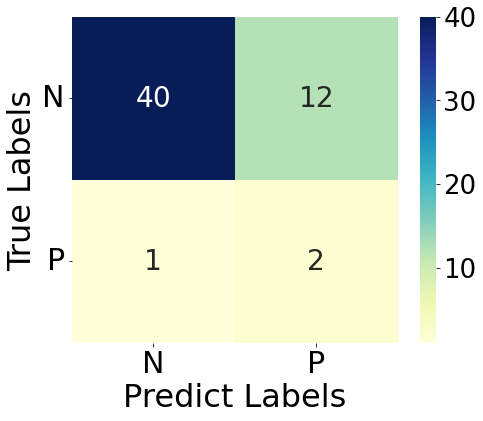

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix , accuracy_score , classification_report, make_scorer,recall_score

# generate confusion matrix
labels1 = ["N", "P"]
plt.figure(figsize = (8, 6))
cm = confusion_matrix(y_test.values,y_predict.argmax(axis=1))
ax = sns.heatmap(cm, square=True, annot=True , cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".0f")   #square=True, annot=True showing number
# plt.matshow(cm)
# plt.title('Confusion matrix CNN', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

# 设置colorbar字体
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.colorbar()
plt.xticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(labels1))], labels1, rotation = 0, fontsize=30)

# 保存高清图像
# plt.savefig('./image/Confusion_matrix_standardization_cnn1.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

In [139]:
cm

array([[40, 12],
       [ 1,  2]], dtype=int64)

In [140]:
predict_matrix = np.zeros(cm.shape)
for i in range(cm.shape[0]):
    temp = np.sum(cm[i])
    for j in range(cm.shape[1]):
        predict_matrix[i,j] = cm[i,j]/temp
predict_matrix

array([[0.76923077, 0.23076923],
       [0.33333333, 0.66666667]])

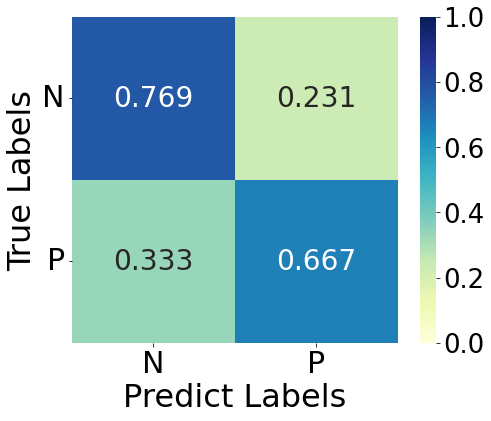

In [141]:
plt.figure(figsize = (8, 6))
ax = sns.heatmap(predict_matrix, square=True, annot=True ,cmap="YlGnBu", annot_kws={"fontsize":28}, fmt=".3f", vmin=0, vmax=1)
plt.xticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)
plt.yticks([i + 0.5 for i in range(len(predict_matrix))], labels1, rotation = 0, fontsize=30)

# 设置colorbar字体
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=26)

# plt.title('Confusion matrix of prediction', fontsize=18)
plt.ylabel("True Labels", fontsize=32)
plt.xlabel("Predict Labels", fontsize=32)

# 保存高清图像
# plt.savefig('./image/Confusion_matrix_standardization_cnn2.jpg', dpi=300, bbox_inches='tight')
# plt.tight_layout()

plt.show()

In [142]:
# calculate evaluation metric using test cohort
accuracy0 = np.round(accuracy_score(y_test.values, 
               y_predict.argmax(axis=1)), decimals = 3)
print('\nCNN Predictive Accuracy: ',accuracy0)


CNN Predictive Accuracy:  0.764


In [143]:
print('\nSummary of CNN Precision and Recall\n') 
print(classification_report(y_test, y_predict.argmax(axis=1), 
                            target_names = labels1, digits=3))


Summary of CNN Precision and Recall

              precision    recall  f1-score   support

           N      0.976     0.769     0.860        52
           P      0.143     0.667     0.235         3

    accuracy                          0.764        55
   macro avg      0.559     0.718     0.548        55
weighted avg      0.930     0.764     0.826        55



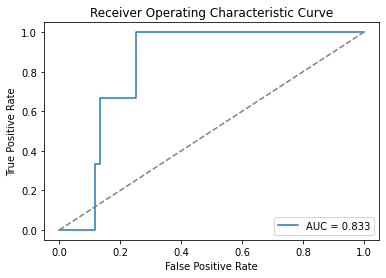

In [144]:
# Calculate AUC score and plot ROC curve
from sklearn.metrics import roc_curve, auc,roc_auc_score

# fpr, tpr, thresholds = roc_curve(label_true.ravel(), label_predict.ravel())
# auc = auc(fpr, tpr)

fpr, tpr, thresholds = roc_curve(y_test, y_predict[:,1])
auc = roc_auc_score(y_test, y_predict[:,1])

plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

# 1预测成0的情况

In [145]:
a = y_test.values
b = np.argmax(y_predict,axis=1)

In [146]:
# 找出1被预测成0的情况
BtoNB = []
i = 0
for each in a:
    if a[i]==1 and a[i]!=b[i]:
        BtoNB.append(i)
#     else:
#         continue   # 千万不要家else continue，要不然i的值永远无法执行+1,也就是永远是0.切记切记！
    i += 1
BtoNB

[26]

In [147]:
# 测试数据中的1被预测成0的情况
BtoNB_text = df_result5.iloc[BtoNB,:]
BtoNB_text

,Blood Gas~Blood~pO2~50821~mm Hg,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Creatinine~50912~mg/dL,Chemistry~Blood~Glucose~50931~mg/dL,Chemistry~Blood~H~50934~_U,Chemistry~Blood~I~50947~_U,Chemistry~Blood~Lactate Dehydrogenase (LD)~50954~IU/L,Chemistry~Blood~Potassium~50971~mEq/L,Chemistry~Blood~Sodium~50983~mEq/L,Hematology~Blood~Hemoglobin~51222~g/dL,Hematology~Blood~Lymphocytes~51244~%,Hematology~Blood~MCHC~51249~%_g/dL,Hematology~Blood~Monocytes~51254~%,Hematology~Blood~Platelet Count~51265~K/uL,Hematology~Blood~PTT~51275~sec,"Chemistry~Cerebrospinal Fluid~Glucose, CSF~51790~mg/dL","Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL",Hematology~Blood~Absolute Monocyte Count~52074~K/uL_,Hematology~Blood~Immature Granulocytes~52135~%,Hematology~Blood~RDW-SD~52172~fL_,Hematology~Cerebrospinal Fluid~Lymphs~52264~%,Hematology~Cerebrospinal Fluid~Macrophage~52266~%,Hematology~Cerebrospinal Fluid~Polys~52281~%,resprate,pain,acuity,culture
26,103.0,2.6,1.11,114.217169,15.834551,1.222261,304.238226,2.9,138.0,10.49476,5.1,33.332792,0.57,130.0,27.0,47.961323,204.0,0.926844,1.11258,13.4,38.915752,10.256786,25.068649,17.298524,11.133421,1.51706,1


In [149]:
df_result5.iloc[:,:]

,Blood Gas~Blood~pO2~50821~mm Hg,Chemistry~Blood~Albumin~50862~g/dL,Chemistry~Blood~Creatinine~50912~mg/dL,Chemistry~Blood~Glucose~50931~mg/dL,Chemistry~Blood~H~50934~_U,Chemistry~Blood~I~50947~_U,Chemistry~Blood~Lactate Dehydrogenase (LD)~50954~IU/L,Chemistry~Blood~Potassium~50971~mEq/L,Chemistry~Blood~Sodium~50983~mEq/L,Hematology~Blood~Hemoglobin~51222~g/dL,Hematology~Blood~Lymphocytes~51244~%,Hematology~Blood~MCHC~51249~%_g/dL,Hematology~Blood~Monocytes~51254~%,Hematology~Blood~Platelet Count~51265~K/uL,Hematology~Blood~PTT~51275~sec,"Chemistry~Cerebrospinal Fluid~Glucose, CSF~51790~mg/dL","Chemistry~Cerebrospinal Fluid~Total Protein, CSF~51802~mg/dL",Hematology~Blood~Absolute Monocyte Count~52074~K/uL_,Hematology~Blood~Immature Granulocytes~52135~%,Hematology~Blood~RDW-SD~52172~fL_,Hematology~Cerebrospinal Fluid~Lymphs~52264~%,Hematology~Cerebrospinal Fluid~Macrophage~52266~%,Hematology~Cerebrospinal Fluid~Polys~52281~%,resprate,pain,acuity,culture
0,97.176040,3.581370,0.42,106.000000,10.462741,1.000000,371.549077,3.9,145.0,12.655385,19.381329,34.000849,6.014953,257.000000,27.941419,69.000000,177.000000,0.901596,0.498579,20.1,38.004927,5.355302,34.759722,19.554708,6.368987,2.571608,0
1,131.206391,4.083304,0.40,118.000000,14.977839,0.362671,194.279123,3.8,138.0,12.995975,13.993161,33.126599,7.259017,405.000000,35.007854,72.000000,69.000000,0.623693,1.598780,20.7,43.400282,8.325270,38.220213,15.677919,2.846855,2.192601,0
2,91.000000,3.490425,0.40,102.000000,8.284068,0.610507,456.249814,3.5,139.0,11.445367,12.603348,33.596347,4.763230,425.000000,29.121501,61.605654,54.360848,0.650581,0.491761,20.6,60.329188,16.151397,5.894390,18.519609,7.996410,2.629340,0
3,111.647862,4.500000,0.50,102.000000,8.749377,1.000000,339.614101,4.0,141.0,10.353926,7.000000,34.180243,5.000000,452.000000,25.000000,51.000000,95.223013,0.435187,0.782388,12.7,66.499947,8.178160,12.602133,18.840620,8.433995,2.705759,0
4,190.386868,4.500000,1.30,135.000000,11.822637,0.391219,207.399409,3.2,142.0,12.533124,7.000000,33.722402,8.000000,301.000000,28.656736,74.000000,54.000000,0.603139,0.440822,16.2,68.095358,5.032481,12.773747,16.117167,3.335632,2.171232,0
5,103.065264,3.800000,1.30,84.000000,48.414245,1.402986,300.614336,4.6,138.0,14.510286,26.000000,34.503186,11.000000,238.000000,30.000000,51.000000,103.000000,0.893257,0.339773,15.0,69.466369,2.899092,25.089698,18.474747,6.699239,2.121141,0
6,202.153683,4.274747,1.00,122.000000,6.636672,0.777825,239.444246,3.3,143.0,11.996067,2.000000,33.805959,3.000000,230.000000,46.000000,76.000000,69.000000,0.926203,0.580813,16.8,60.472979,22.821028,11.144142,16.269512,3.175297,1.838491,0
7,158.688486,3.735222,1.00,125.000000,13.541556,1.000000,327.731716,3.6,145.0,11.749022,15.235101,34.276753,4.773900,166.000000,29.951441,93.000000,514.000000,0.870887,0.824946,13.3,41.583415,8.991163,37.455935,18.462649,6.809290,1.768496,0
8,103.000000,2.800000,1.20,171.000000,18.071917,0.594928,357.332819,3.8,138.0,9.602584,10.000000,33.362086,8.000000,405.000000,39.000000,134.000000,29.000000,1.138415,1.735344,12.6,59.925492,3.588277,28.640336,16.766585,5.970933,2.207235,0
9,144.000000,4.279655,1.30,213.000000,4.624149,0.703890,237.257833,4.8,137.0,13.868374,22.544522,34.652262,4.763236,330.000000,28.866041,75.954595,679.017278,0.429026,0.499508,13.4,63.450455,7.094719,20.398457,18.796569,6.326888,2.568034,1
